<a href="https://colab.research.google.com/github/keropfia/Primary-models/blob/main/B.%20cereus%20in%20shumai%20at%2015C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.5 MB/s eta 0:00:00


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from lmfit import Model

In [34]:
df = pd.read_excel("B. cereus growth data.xlsx")
print(df)

    Time (h)      Rep1      Rep2      Rep3      logN        sd
0          0  3.982365  3.827031  3.911132  3.906842  0.077756
1          4  3.846654  3.763745  3.932556  3.847652  0.084410
2          8  3.963752  3.930527  3.918763  3.937681  0.023332
3         12  3.520305  3.927485  3.788320  3.745370  0.206960
4         16  3.969261  3.861798  3.770790  3.867283  0.099349
5         20  3.930336  3.849437  3.980016  3.919929  0.065909
6         24  4.429522  4.523595  4.414396  4.455838  0.059165
7         28  4.277665  4.385004  4.305009  4.322559  0.055780
8         32  5.173528  5.226381  5.125501  5.175137  0.050459
9         36  5.016071  4.831717  4.909100  4.918963  0.092572
10        40  5.611515  5.624286  5.641800  5.625867  0.015204
11        44  5.581323  5.643726  5.676382  5.633810  0.048299
12        48  6.577803  6.559915  6.654384  6.597367  0.050182
13        56  6.892184  6.846321  6.935704  6.891403  0.044697
14        64  7.758486  7.522454  7.654999  7.645313  0

In [77]:
df['Mean'] = df[['Rep1', 'Rep2', 'Rep3']].mean(axis=1)
df['Std'] = df[['Rep1', 'Rep2', 'Rep3']].std(axis=1)

In [78]:
def baranyi_dmfit(t, y0, y_end, umax, lag):
    """
    Baranyi growth model in log10 scale (DMFit-compatible)

    Parameters
    ----------
    t : time (h)
    y0 : initial log10 population
    y_end : final log10 population
    umax : maximum growth rate (log10 units per hour)
    lag : lag time (h)
    """
    ln10 = np.log(10.0)
    t = np.array(t)
    numerator = -1 + np.exp(ln10 * umax * lag) + np.exp(ln10 * umax * t)
    denominator = -1 + np.exp(ln10 * umax * t) + np.exp(ln10 * umax * lag) * 10 ** (y_end - y0)
    return y_end + np.log10(numerator / denominator)

In [79]:
model = Model(baranyi_dmfit)

params = model.make_params(
    y0=df['Mean'].iloc[0],              # start from first measured log10 value
    y_end=df['Mean'].max(),             # use max observed value as guess
    umax=0.1,                           # initial guess (log10/h)
    lag=5                               # initial guess for lag time (h)
)

In [80]:
params['y0'].min = 0
params['y_end'].min = params['y0'].value
params['umax'].min = 0
params['lag'].min = 0

In [81]:
result = model.fit(df['Mean'], params, t=df['Time (h)'])

In [82]:
t_smooth = np.linspace(df['Time (h)'].min(), df['Time (h)'].max(), 200)
y_pred = baranyi_dmfit(t_smooth, **result.best_values)

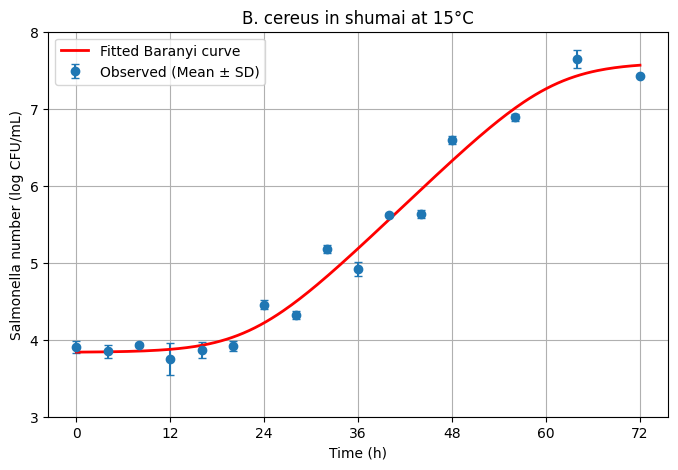

In [102]:
plt.figure(figsize=(8,5))
plt.errorbar(df['Time (h)'], df['Mean'], yerr=df['Std'], fmt='o', capsize=3, label='Observed (Mean ± SD)')
plt.plot(t_smooth, y_pred, 'r-', lw=2, label='Fitted Baranyi curve')
plt.xlabel('Time (h)')
plt.xticks(np.arange(0, max(t_smooth)+12, 12))
plt.ylabel('Salmonella number (log CFU/mL)')
plt.yticks(np.arange(3, np.ceil(max(y_pred))+1, 1))
plt.legend()
plt.title('B. cereus in shumai at 15\u00B0C')
plt.grid(True)
plt.show()

In [84]:
print(result.fit_report())

[[Model]]
    Model(baranyi_dmfit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 16
    # variables        = 4
    chi-square         = 0.58011134
    reduced chi-square = 0.04834261
    Akaike info crit   = -45.0739833
    Bayesian info crit = -41.9836284
    R-squared          = 0.97932693
[[Variables]]
    y0:     3.83877524 +/- 0.10569211 (2.75%) (init = 3.906842)
    y_end:  7.59806917 +/- 0.20883854 (2.75%) (init = 7.645313)
    umax:   0.09822426 +/- 0.01048786 (10.68%) (init = 0.1)
    lag:    22.4710802 +/- 2.62662202 (11.69%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(umax, lag)   = +0.8206
    C(y0, lag)     = +0.7048
    C(y_end, umax) = -0.4105
    C(y0, umax)    = +0.3381
    C(y_end, lag)  = -0.2612
    C(y0, y_end)   = -0.1069


In [91]:
df_orig = df[["Time (h)", "Mean", "Std"]].copy()

In [95]:
print(y_pred)

[3.83877524 3.83900496 3.83925413 3.83952438 3.83981749 3.84013537
 3.84048009 3.84085389 3.84125921 3.84169866 3.84217508 3.84269154
 3.84325134 3.84385806 3.84451555 3.84522799 3.84599986 3.84683599
 3.84774161 3.84872232 3.84978415 3.8509336  3.85217762 3.85352371
 3.85497987 3.85655469 3.85825736 3.8600977  3.86208617 3.86423395
 3.86655292 3.86905568 3.87175564 3.87466694 3.87780457 3.88118427
 3.88482264 3.88873706 3.89294571 3.89746753 3.90232222 3.90753017
 3.91311239 3.91909048 3.92548652 3.93232295 3.9396225  3.94740803
 3.95570238 3.96452822 3.97390787 3.9838631  3.994415   4.00558368
 4.01738814 4.02984607 4.04297359 4.05678514 4.07129326 4.08650843
 4.10243898 4.11909094 4.13646797 4.15457132 4.17339981 4.19294985
 4.21321547 4.2341884  4.2558582  4.27821236 4.30123647 4.32491441
 4.34922848 4.37415966 4.39968776 4.42579165 4.45244946 4.47963876
 4.50733675 4.53552044 4.5641668  4.5932529  4.62275609 4.65265406
 4.68292493 4.71354742 4.74450083 4.77576514 4.80732104 4.8391